In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import re
from sklearn.preprocessing import LabelEncoder
import string
import pickle

from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Bidirectional, GlobalMaxPool1D, LSTM, Dropout, Conv1D, Flatten, MaxPool1D
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_data = pd.read_csv('datasets/Corona_NLP_train.csv',encoding='latin1')
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
test_data = pd.read_csv('datasets/Corona_NLP_test.csv',encoding='latin1')
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [6]:
train_data = train_data.drop(columns=['UserName','ScreenName','Location','TweetAt'])
test_data = test_data.drop(columns=['UserName','ScreenName','Location','TweetAt'])

In [7]:
train_data.head(2)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive


In [8]:
test_data.head(2)

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

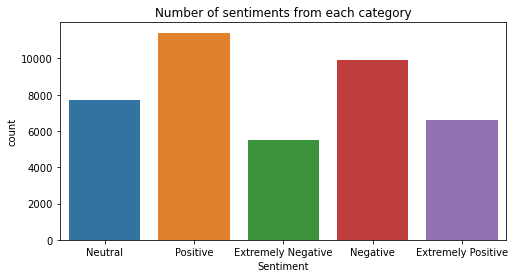

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(train_data['Sentiment'])
plt.title("Number of sentiments from each category")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

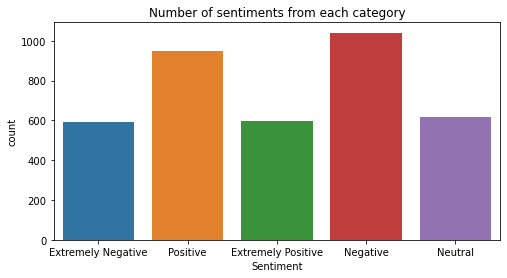

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(test_data['Sentiment'])
plt.title("Number of sentiments from each category")
plt.show()

## Preprocessing functions:-

In [11]:
def clean(text):
    
    # Loading stopwords:-
    stop_words = stopwords.words('english')
    
    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)
    
    # remove urls
    text = re.sub(r'http\S+', " ", text)

    # remove mentions
    text = re.sub(r'@\w+',' ',text)

    # remove digits
    text = re.sub(r'\d+', ' ', text)

    # remove html
    text = re.sub('r<.*?>',' ', text)
    
    # convert to lowercase:-
    text = text.lower()
    
    # Replace punctuation with whitespaces:-
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    text = re.sub(re_punc,"", text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    
      
    return text

In [12]:
# Creating a feature encoding dictionary. Only mapping Positive, negative and neutral sentiments for simplicity:
label_encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']  # Negative -> 0, Neutral -> 1, Positive -> 2

In [13]:
train_data['Sentiment'] = train_data['Sentiment'].map(label_encoding)

## Preparing data for modelling:-

In [14]:
X = train_data['OriginalTweet'].copy()
y = train_data['Sentiment'].copy()

In [15]:
X_cleaned = X.apply(clean)

In [16]:
X_cleaned[15]

'lines grocery store unpredictable eating safe alternative find whether avoiding restaurants right'

In [17]:
# Instantiating the tokenizer:-
tokenizer = Tokenizer()

# Fitting the tokenizer:-
tokenizer.fit_on_texts(X_cleaned)

# Convert to sequences
X_tokenized = tokenizer.texts_to_sequences(X_cleaned)

vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("Sentence:\n{}".format(X_cleaned[4]))
print("\nAfter tokenizing :\n{}".format(X_tokenized[4]))

X_padded = pad_sequences(X_tokenized, padding='post')
print("\nPadded sequences :\n{}".format(X_padded[4]))

print("\nLength of sequences: \n{}".format(len(X_padded[4])))

Vocabulary size: 39012
Sentence:
ready go supermarket outbreak im paranoid food stock litteraly empty serious thing please dont panic causes shortage

After tokenizing :
[606, 20, 5, 57, 105, 3783, 4, 27, 18321, 127, 677, 199, 33, 64, 17, 1513, 326]

Padded sequences :
[  606    20     5    57   105  3783     4    27 18321   127   677   199
    33    64    17  1513   326     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]

Length of sequences: 
41


In [18]:
X_padded.shape[1]

41

# Model:-

In [19]:
K.clear_session()

In [20]:
vocab_size = len(tokenizer.word_index)+1
batch_size = 64
sequence_len = len(X_padded[0])

# define model

model = Sequential()
model.add(Embedding(vocab_size,32,input_length=sequence_len))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# Compiling model:-
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# Summarising:-
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 32)            1248384   
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 512)           591872    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [21]:
# Fitting the model:
model.fit(X_padded,y,batch_size=batch_size,epochs=2,validation_split=0.15)

Epoch 1/2
547/547 [==============================] - 154s 282ms/step - loss: 0.6972 - accuracy: 0.6876 - val_loss: 0.4195 - val_accuracy: 0.8578
Epoch 2/2
547/547 [==============================] - 158s 288ms/step - loss: 0.3331 - accuracy: 0.8911 - val_loss: 0.4038 - val_accuracy: 0.8602


In [23]:
vocab_size = len(tokenizer.word_index)+1
batch_size = 32
sequence_len = len(X_padded[0])

# define model

model_v2 = Sequential()
model_v2.add(Embedding(vocab_size, 32, input_length=sequence_len))
model_v2.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
model_v2.add(MaxPool1D(pool_size=2))
model_v2.add(Flatten())
model_v2.add(Dense(10, activation='relu'))
model_v2.add(Dense(3, activation='softmax'))

# Compiling model:-
model_v2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# Summarising:-
model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 32)            1248384   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 128)           32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                21770     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 33        
Total params: 1,303,083
Trainable params: 1,303,083
Non-trainable params: 0
____________________________________________

In [24]:
model_v2.fit(X_padded,y,batch_size=batch_size,epochs=2,validation_split=0.15)

Epoch 1/2
1094/1094 [==============================] - 23s 21ms/step - loss: 0.6576 - accuracy: 0.7219 - val_loss: 0.4352 - val_accuracy: 0.8537
Epoch 2/2
1094/1094 [==============================] - 24s 22ms/step - loss: 0.3096 - accuracy: 0.9001 - val_loss: 0.4343 - val_accuracy: 0.8513


## Saving the tokenizer and the models:-

In [25]:
def save(model,model_name):
    # Save the trained weights
    model.save_weights('models/{}_weights.h5'.format(model_name))

    # Save the model architecture
    with open('models/{}_architecture.json'.format(model_name), 'w') as f:
        f.write(model.to_json())

In [28]:
# Saving the RNN model and architecture to a single file:-

save(model,"RNN_embedding_model")
print('Saved {} to disk'.format(model))
print("\n\n")
save(model_v2,"CNN_embedding_model")
print('Saved {} to disk'.format(model_v2))

Saved <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CFEE97D760> to disk



Saved <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CF84B2A9A0> to disk


In [29]:
# Save the tokenizer
with open('models/tokenizer.json', 'w') as f:
    f.write(tokenizer.to_json())

## Preprocessing test data:

In [38]:
def load_models():
    with open('models/tokenizer.json') as f:
        tokenizer = tokenizer_from_json(f.read())

    # RNN Model reconstruction from JSON file
    with open('models/RNN_embedding_model_architecture.json', 'r') as f:
        RNN_model = model_from_json(f.read())

    # Load RNN weights into the new model
    RNN_model.load_weights('models/RNN_embedding_model_weights.h5')
    
    # CNN Model reconstruction from JSON file
    with open('models/CNN_embedding_model_architecture.json', 'r') as f:
        CNN_model = model_from_json(f.read())

    # Load CNN weights into the new model
    CNN_model.load_weights('models/CNN_embedding_model_weights.h5')   

    return RNN_model, CNN_model, tokenizer

In [39]:
RNN_model, CNN_model, tokenizer = load_models()

In [41]:
test_data['Sentiment'] = test_data['Sentiment'].map(label_encoding)

In [42]:
X_test = test_data['OriginalTweet'].copy()
y_test = test_data['Sentiment'].copy()

In [43]:
X_test_cleaned = X.apply(clean)

In [44]:
test_tokenized = tokenizer.texts_to_sequences(X_test_cleaned)
test_padded = pad_sequences(test_tokenized, padding='post')

In [45]:
len(test_padded[0])

41

In [46]:
RNN_pred = np.argmax(RNN_model.predict(test_padded),axis=-1)

In [47]:
CNN_pred = np.argmax(CNN_model.predict(test_padded),axis=-1)

# Calculating metrics:-

In [48]:
print("Confusion matrix for the RNN model: \n\n{}".format(confusion_matrix(y,RNN_pred)))

Confusion matrix for the RNN model: 

[[13800   199  1399]
 [  365  6636   712]
 [  407    74 17565]]


In [49]:
print("Classification report for the RNN model: \n\n{}".format(classification_report(y,RNN_pred)))

Classification report for the RNN model: 

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     15398
           1       0.96      0.86      0.91      7713
           2       0.89      0.97      0.93     18046

    accuracy                           0.92     41157
   macro avg       0.93      0.91      0.92     41157
weighted avg       0.93      0.92      0.92     41157



In [50]:
print("Confusion matrix for the CNN model: \n\n{}".format(confusion_matrix(y,CNN_pred)))

Confusion matrix for the CNN model: 

[[14604   212   582]
 [  530  6639   544]
 [  618   111 17317]]


In [51]:
print("Classification report for the CNN model: \n\n{}".format(classification_report(y,CNN_pred)))

Classification report for the CNN model: 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     15398
           1       0.95      0.86      0.90      7713
           2       0.94      0.96      0.95     18046

    accuracy                           0.94     41157
   macro avg       0.94      0.92      0.93     41157
weighted avg       0.94      0.94      0.94     41157



### The deep CNN model with embedding gives better overall metrics. 